# Aprendizaje de Máquinas (Machine Learning)
## Clase 3: Regresión

### 1. Configuración del ambiente

Antes que empezar a trabajar, vamos a preparar el ambiente.
Para ello:
* Montamos Google Drive para guardar allí los archivos que descarguemos. En la consola nos va a aparecer una solicitud para hacer clic en una URL, loggearnos con nuestra cuenta de Google y colocar un código de autorización en una casilla.

In [ ]:
# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs, path
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Machine Learning/'
makedirs(datasets_folder, exist_ok=True)

# importo numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales

# importo una librería para utilizar valores aleatorios
import random

# importo matplotlib
import matplotlib.pyplot as plt

Mounted at /content/gdrive/


### 2. Acceso a datos de la clase pasada

Vamos a trabajar con la partición en datos de entrenamiento, validación y test del ```housing_dataset``` que usamos en clase 1 y 2. Si el archivo no está disponible en Google Drive, volvé al Colab de la Clase 1 y ejecutá todos los bloques de código.

In [ ]:
# establecemos la ruta al archivo (si la cambiaron la clase pasada, corregir por
# la ruta correcta)
dataset_filename = path.join(datasets_folder, 'housing_dataset_partitioned.pkl')

# cargamos los datos preparados
import pickle
with open(dataset_filename, 'rb') as f:
    dataset = pickle.load(f)
# verificamos si los datos están bien cargados
print('Variables in dataset object: {}'.format(dataset.keys()))

Variables in dataset object: dict_keys(['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'feature_labels', 'mu', 'sigma'])


### 3. Regresión lineal

Los modelos de [regresión lineal (linear regression)](https://en.wikipedia.org/wiki/Simple_linear_regression) permiten resolver problemas de regresión en los cuales los vectores de features $\mathbf{x}$ tienen una relación lineal con la variable objetivo $y$. También pueden adaptarse para trabajar con variables que tienen alguna otra dependencia (por ejemplo, [polinómica](https://en.wikipedia.org/wiki/Polynomial_regression))

El modelo que se aprende tiene una serie de parámetros $\theta_i$ que, combinados linealmente con cada feature $x_i$, permiten obtener la estimación de la variable objetivo $\hat{y}$:

$\hat{y} = \theta_1 · x_1 + \theta_2 · x_2 + ... + \theta_d · x_d = \sum_{i=1}^d \theta_i · x_i$

El modelo tiene una interpretación geométrica. Si solamente tuviéramos una única feature, la ecuación $\hat{y} = \theta x$ es la de una recta que pasa por el origen de coordenadas (el punto $(x=0, y=0)$). Si tuviéramos dos variables, la ecuación $\hat{y} = \theta_1 x_1 + \theta_2 x_2$ es la de un plano que pasa por el origen de coordenadas (el punto $(x_1=0, x_2=0, y=0)$). En más dimensiones, la ecuación representa lo que en álgebra lineal se conoce como hiperplano. Rectas (1D), planos (2D) e hiperplanos (3D o más) son combinaciones lineales de variables y pesos. Por eso decimos que el modelo de regresión lineal sirve para ajustar / predecir datos que son lineales respecto a la variable objetivo.

Vamos a entrenar a continuación un modelo clásico de regresión lineal que nos resuelve el problema ya clásico de predecir el precio de un inmueble de Boston a partir de sus características. Dado que los datos ya están normalizados (lo hicimos en la clase 1), podemos setear el parámetro ```normalize``` en ```False```. Sobre ```fit_intercept``` hablaremos en un rato.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# inicializamos un modelo de regresion lineal que no normaliza ni aprende una
# ordenada al origen
linear_regression_model = LinearRegression(fit_intercept=False, normalize=False)
# lo entrenamos
linear_regression_model.fit(dataset['X_train'], dataset['y_train'])
# y lo evaluamos sobre los datos de training utilizando MSE
y_hat_train = linear_regression_model.predict(dataset['X_train'])
mse = mean_squared_error(dataset['y_train'], y_hat_train)
print('Simple linear regression model:')
print('MSE in training data = {:.4f}'.format(mse))

Simple linear regression model:
MSE in training data = 533.6963


El modelo clásico de regresión lineal no tiene hiperparámetros que afecten sensiblemente el entrenamiento. Sin embargo, hay un factor que es importante considerar. 

Rara vez ocurre que la variable objetivo $y = 0$ cuando todas las features $x_i = 0$. Si no tuviéramos esto en cuenta, el modelo intentará siempre pasar por el origen, y eso hará que no funcione bien al evaluarse muestras con features cercanas a 0. Para corregir eso, podemos pedirle al modelo que aprenda también la ordenada al origen de la recta / plano / hiperplano (o intercept en inglés). En sklearn, la forma de hacerlo es simplemente pedirle al modelo que lo aprenda. En otras librerías, se resuelve agregando a todas las muestras una feature extra, constante e igual a 1. El algoritmo aprenderá entonces un valor $\theta$ para esa feature, que multiplicado por 1 equivale a esa famosa ordenada al origen.

Probemos qué pasa con el error de training al pedirle al modelo que aprenda la ordenada al origen (```fit_intercept = True```).

In [ ]:
# inicializamos un modelo de regresion lineal que no normaliza pero que sí
# aprende la ordenada al origen
linear_regression_model_with_intercept = LinearRegression(fit_intercept=True, normalize=False)
# lo entrenamos
linear_regression_model_with_intercept.fit(dataset['X_train'], dataset['y_train'])
# y lo evaluamos sobre los datos de training utilizando MSE
y_hat_train = linear_regression_model_with_intercept.predict(dataset['X_train'])
mse_standard_regression_with_intercept = mean_squared_error(dataset['y_train'], y_hat_train)
print('Simple linear regression model:')
print('MSE in training data:')
print('w/o intercept \t MSE = {:.4f}'.format(mse))
print('with intercept \t MSE = {:.4f}'.format(mse_standard_regression_with_intercept))

Simple linear regression model:
MSE in training data:
w/o intercept 	 MSE = 533.6963
with intercept 	 MSE = 29.1853


### 4. Regresión lineal regularizada: Ridge Regression

El modelo de regresión lineal tradicional es susceptible a sufrir de overfitting, ya que no tiene nada que lo ayude a controlar que no suceda. En general, el overfitting del modelo simple suele aparecer cuando los datos de entrenamiento tienen una feature muy correlacionada con la variable objetivo. En ese caso, el modelo intentará ignorar al resto (aprendiendo valores de $\theta_i=0$) y prestar atención únicamente a la feature correlacionada ($\theta_j=1$).

El modelo de [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) introduce un término adicional a la función de error que se optimiza durante el entrenamiento (en la jerga matemática y de machine learning, un **regularizador**) que penaliza que el modelo se centre demasiado en utilizar pocas features. Para controlar el balance entre el regularizador y el error, se utiliza un parámetro $\lambda \geq 0$ (en ```sklearn```, $\alpha$) que indica la "fuerza" del regularizador: cuanto más alto es, más atención se le presta al regularizador y menos a la función de error; cuanto más cercano a 0 es, más atención le presta a la función de error y menos al regularizador (más se parece al modelo clásico de regresión).

Vamos a entrenar ahora modelos de Ridge Regression utilizando tres valores posibles de $\alpha$: uno muy alto, uno muy bajo, y otro intermedio. Analizaremos qué pasa con el MSE sobre los datos de entrenamiento, y veremos si alguno de los tres modelos sufre de underfitting. También incluiremos la performance del modelo sin regularización, para poder compararlo con el resto.

In [ ]:
from sklearn.linear_model import Ridge

# valores de alpha que vamos a evaluar
alpha_values = [0.0001, 1.0, 10.0, 100.0, 10000]
ridge_models = []

print('Model comparison on the TRAINING SET:')
print('Simple linear regression. \t MSE = {:.4f}'.format(mse_standard_regression_with_intercept))
for alpha in alpha_values:
  # inicializamos un modelo de Ridge regression
  ridge_model = Ridge(alpha=alpha, fit_intercept=True, normalize=False)
  # lo entrenamos
  ridge_model.fit(dataset['X_train'], dataset['y_train'])
  ridge_models.append(ridge_model)
  # y lo evaluamos sobre los datos de training utilizando MSE
  y_hat_train = ridge_model.predict(dataset['X_train'])
  current_mse = mean_squared_error(dataset['y_train'], y_hat_train)
  print('Ridge with alpha: {:.4f} \t MSE = {:.4f}'.format(alpha, current_mse))

Model comparison on the TRAINING SET:
Simple linear regression. 	 MSE = 29.1853
Ridge with alpha: 0.0001 	 MSE = 29.1853
Ridge with alpha: 1.0000 	 MSE = 29.1883
Ridge with alpha: 10.0000 	 MSE = 29.3642
Ridge with alpha: 100.0000 	 MSE = 32.4340
Ridge with alpha: 10000.0000 	 MSE = 74.2243


Si evaluamos estos tres modelos sobre los datos de validación, podemos también discutir si alguno sufre de overfitting. Incluiremos también en la comparación al modelo de regresión lineal tradicional (con ordenada al origen), para ver si el regularizador mejoró nuestros resultados.

In [ ]:
print('Model comparison in terms of MSE on the VALIDATION SET')
mse_ridge_regression = np.zeros(len(alpha_values))

# evaluamos el modelo de regresión lineal tradicional
y_hat_val = linear_regression_model_with_intercept.predict(dataset['X_val'])
mse_val_simple_linear_regression = mean_squared_error(dataset['y_val'], y_hat_val)
print('Simple linear regression. \t MSE = {:.4f}'.format(mse_val_simple_linear_regression))
# y el resto de los modelos
for i in range(len(ridge_models)):
  # y lo evaluamos sobre los datos de training utilizando MSE
  y_hat_val = ridge_models[i].predict(dataset['X_val'])
  current_mse = mean_squared_error(dataset['y_val'], y_hat_val)
  mse_ridge_regression[i] = current_mse
  print('Ridge with alpha: {:.4f} \t MSE = {:.4f}'.format(alpha_values[i], current_mse))

# identificamos el valor de alpha que nos da mejores resultados
best_alpha_ridge_idx = np.argmin(mse_ridge_regression)
best_alpha_ridge = alpha_values[best_alpha_ridge_idx]
best_mse_ridge = mse_ridge_regression[best_alpha_ridge_idx]
best_ridge_model = ridge_models[best_alpha_ridge_idx]
print('=============================')
print('Best Ridge regression model: alpha={} - MSE = {:.4f}'.format(best_alpha_ridge, best_mse_ridge))

Model comparison in terms of MSE on the VALIDATION SET
Simple linear regression. 	 MSE = 39.4384
Ridge with alpha: 0.0001 	 MSE = 39.4384
Ridge with alpha: 1.0000 	 MSE = 39.4191
Ridge with alpha: 10.0000 	 MSE = 39.4136
Ridge with alpha: 100.0000 	 MSE = 40.4295
Ridge with alpha: 10000.0000 	 MSE = 55.6064
Best Ridge regression model: alpha=10.0 - MSE = 39.4136


Para concluir, recordemos que $\alpha$ es un hiperparámetro que deberemos calibrar utilizando datos de validación o haciendo cross-validation sobre los datos de entrenamiento.

### 5. Regresión lineal regularizada: LASSO

El regularizador en el modelo de Ridge Regression intenta que le prestemos atención a todas las features más o menos igual. Sin embargo, ¿qué pasa si entre las features hay algunas que no sirven demasiado? En ese caso, y dependiendo de la fuerza que le pongamos al regularizador, puede ocurrir que la performance termine siendo peor!

En la clase anterior vimos que una forma de descartar features es hacer feature selection. La alternativa más cara pero que nos asegura descubrir la combinación óptima de features es usar backtracking. Más barato que backtracking es un algoritmo greedy que aproxime la solución óptima (por ejemplo, el de forward selection que vimos antes). 

La tercer opción es aprender un vector de pesos $\theta$ que sea ralo (sparse). Un vector o matriz sparse es aquel o aquella que tiene un montón de sus elementos en 0. En el caso del vector de pesos, esto equivaldría a tener un modelo que ignora features que no le sirven.

El modelo de regresión lineal regularizada Lasso justamente fuerza al modelo a aprender un vector de pesos ralo. Como para ello incluye un regularizador, también tiene su peso $\lambda$ (o $\alpha$), con un rol similar al del model de Ridge Regression.

Vamos a entrenar un único modelo Lasso con $\alpha=10$, y comparar los parámetros que aprende con su equivalente Ridge Regression.

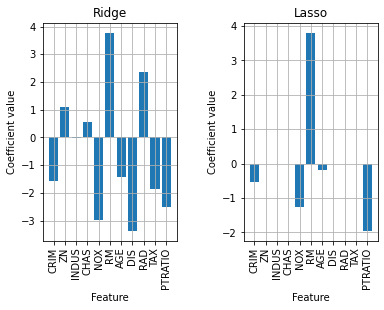

{'CRIM': 'tasa de criminalidad per cápita por ciudad', 'ZN': 'proporción de tierra residencial (dividida en zonas para lotes de más de 25.000 pies cuadrados)', 'INDUS': 'proporción de negocios no minoristas (medida en acres por ciudad)', 'CHAS': 'límite con el río Charles (= 1 si limita; 0 si no)', 'NOX': 'concentración de óxido nítrico (partes por 10 millones)', 'RM': 'cantidad promedio de habitaciones por vivienda', 'AGE': 'proporción de unidades ocupadas por sus propietarios construidas antes de 1940', 'DIS': 'distancias ponderadas a cinco centros de empleo de Boston', 'RAD': 'índice de accessibilidad a carreteras radiales', 'TAX': 'tasa de impuesto a la propiedad de valor total por U$D 10.000', 'PTRATIO': 'tasa alumno/profesor por localidad'}


In [ ]:
from sklearn.linear_model import Lasso

# inicializamos listas de modelos a entrenar y sus nombres
models = [Ridge(alpha=1.0, fit_intercept=True, normalize=False), # Ridge Regression
          Lasso(alpha=1.0, fit_intercept=True, normalize=False)] # Lasso
model_names = ['Ridge', 'Lasso']

# inicializamos los gráficos
fig, axes = plt.subplots(1, len(models))
plt.subplots_adjust(wspace=0.5)
# y entrenamos los modelos
i=0
for model in models:
  # entrenamos el modelo
  model.fit(dataset['X_train'], dataset['y_train'])
  # sacamos los coeficientes
  theta=model.coef_
  # mostramos graficamente los pesos
  axes[i].bar(np.arange(np.squeeze(theta.size)), np.squeeze(theta))
  axes[i].set_title(model_names[i])
  axes[i].set_xlabel('Feature')
  axes[i].set_ylabel('Coefficient value')
  axes[i].set_xticks(np.arange(theta.size))
  axes[i].set_xticklabels(labels=dataset['feature_labels'],rotation = 90)
  axes[i].grid(True)
  i = i+1
plt.show()
print(dataset['feature_labels'])

Puede verse que en el caso de LASSO, el modelo tiene  más parámetros en 0. De alguna manera, estamos haciendo feature selection al mismo tiempo que entrenamos!

¿Nos conviene hacer esto siempre? No. En algunos casos LASSO puede ser demasiado agresivo, enviando a 0 muchos parámetros e ignorando demasiadas features. En otros casos LASSO nos puede ayudar a sortear el hecho de tener muchas features y facilitarnos tener que hacer un proceso de grid search muy grande para seleccionar las features.

Probemos como hicimos antes diferentes valores para $\lambda$ (o $\alpha$) y comparemos los resultados con el mejor modelo de Ridge regression.

In [ ]:

# valores de alpha que vamos a evaluar
alpha_values = [0.0001, 0.01, 1.0, 10.0, 100.0, 10000]
# valores de MSE obtenidos por cada modelo
mse_lasso_regression = np.zeros(len(alpha_values))
# lista donde guardar los modelos LASSO
lasso_models = []

# iteramos por cada valor de alpha y vamos entrenando distintos modelos y
# evaluando cada uno sobre los datos de validacion
i=0
for alpha in alpha_values:
  # inicializamos un modelo LASSO
  lasso_model = Lasso(alpha=alpha, fit_intercept=True, normalize=False)
  lasso_models.append(lasso_model)
  # lo entrenamos
  lasso_model.fit(dataset['X_train'], dataset['y_train'])
  # y lo evaluamos sobre los datos de validation
  y_hat_val = lasso_model.predict(dataset['X_val'])
  current_mse = mean_squared_error(dataset['y_val'], y_hat_val)
  mse_lasso_regression[i] = current_mse
  print('LASSO with alpha: {:.4f} \t MSE = {:.4f}'.format(alpha_values[i], current_mse))
  i = i+1

# identificamos el valor de alpha que nos da mejores resultados
best_alpha_lasso_idx = np.argmin(mse_lasso_regression)
best_alpha_lasso = alpha_values[best_alpha_lasso_idx]
best_mse_lasso = mse_lasso_regression[best_alpha_lasso_idx]
best_lasso_model = lasso_models[best_alpha_lasso_idx]
print('=============================')
print('Best LASSO regression model in the validation set: alpha={:.4f} \t MSE={:.4f}'.format(best_alpha_lasso, best_mse_lasso))
print('=============================')
print('Best Ridge regression model in the validation set: alpha={:.4f} \t MSE={:.4f}'.format(best_alpha_ridge, best_mse_ridge))
  

LASSO with alpha: 0.0001 	 MSE = 39.4383
LASSO with alpha: 0.0100 	 MSE = 39.4741
LASSO with alpha: 1.0000 	 MSE = 46.0755
LASSO with alpha: 10.0000 	 MSE = 60.5650
LASSO with alpha: 100.0000 	 MSE = 60.5650
LASSO with alpha: 10000.0000 	 MSE = 60.5650
Best LASSO regression model in the validation set: alpha=0.0001 	 MSE=39.4383
Best Ridge regression model in the validation set: alpha=10.0000 	 MSE=39.4136


Podemos ver que, de acuerdo a los valores de MSE que obtenemos, el modelo LASSO actúa mejor cuando el valor de alpha es bajo. Esto significa que el modelo si casi se ignora el regularizador, lo que en principio sugiere que sería preferible utilizarlo sin ese término. 

En conclusión, cuando tengan un problema de regresión y quieran probar un método de regresión lineal, siempre es recomendable probar Ridge y LASSO y comparar uno con otro. Si ven que LASSO es peor que Ridge, pueden hacer algo de feature selection con Ridge regression para mejorar un poco los valores. Y, eventualmente, contrastar ese modelo final con el próximo que veremos a continuación.

### 6. Random Forest Regression

Random Forest es un modelo de machine learning basado en ensambles que nos permite hacer tanto regresión como clasificación. Los modelos basados en ensambles integran las respuestas de varios submodelos para producir una respuesta final. En el caso de RF, se cuenta con varios árboles de decisión entrenados a partir de particiones aleatorias de los datos de entrenamientos y subconjuntos de características.

Vamos a hacer una primera prueba del método de RF regression usando diferentes cantidades de árboles, y evaluando cada uno sobre los datos de validación. También vamos a tomar el tiempo que demora cada entrenamiento y cada ejecución de validación, para ver cómo afecta el número de árboles al costo computacional del algoritmo.

RF regression
N = 50 - MSE = 22.5433 - Train time = 0.1199 s - Pred time = 0.0038 s
N = 100 - MSE = 29.6400 - Train time = 0.2305 s - Pred time = 0.0069 s
N = 200 - MSE = 27.9376 - Train time = 0.4683 s - Pred time = 0.0161 s
N = 300 - MSE = 28.3151 - Train time = 0.7034 s - Pred time = 0.0198 s
N = 400 - MSE = 28.1095 - Train time = 0.9342 s - Pred time = 0.0287 s
N = 500 - MSE = 27.6402 - Train time = 1.1592 s - Pred time = 0.0326 s
N = 1000 - MSE = 28.9749 - Train time = 2.3245 s - Pred time = 0.0743 s


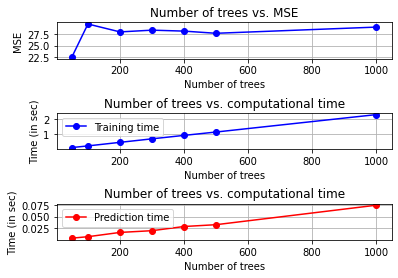

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import time

# numero de arboles
num_trees = [50, 100, 200, 300, 400, 500, 1000]
# tiempos de entrenamiento y prediccion
training_time = np.zeros(len(num_trees))
prediction_time = np.zeros(len(num_trees))
# inicializamos una lista de modelos
rf_models = []

# arreglo para ir guardando los valores de MSE
mse_rf_regression = np.zeros(len(num_trees))

# iteramos por cada numero de arboles
i = 0
print('RF regression')
print('================')
for N in num_trees:
  # definimos el modelo
  model = RandomForestRegressor(n_estimators=N, random_state=10)
  # lo entrenamos sobre los datos de entrenamiento, midiendo el tiempo que lleva
  start_time = time.time()
  model.fit(dataset['X_train'], np.squeeze(dataset['y_train']))
  training_time[i] = time.time() - start_time
  rf_models.append(model)
  # predecimos sobre los datos de validación, registrando el tiempo que lleva
  start_time = time.time()
  y_hat_val = model.predict(dataset['X_val'])
  prediction_time[i] = time.time() - start_time
  # evaluamos el MSE
  mse_rf_regression[i] = mean_squared_error(dataset['y_val'], y_hat_val)
  # imprimimos las estadisticas
  print('N = {} - MSE = {:.4f} - Train time = {:.4f} s - Pred time = {:.4f} s'.format(N, mse_rf_regression[i], training_time[i], prediction_time[i]))
  i = i+1
print('================')

# inicializamos los gráficos
fig, axes = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)
# mostramos graficamente la evolución del MSE
axes[0].plot(np.asarray(num_trees), mse_rf_regression, '-bo')
axes[0].set_title('Number of trees vs. MSE')
axes[0].set_xlabel('Number of trees')
axes[0].set_ylabel('MSE')
axes[0].grid(True)
# y el tiempo en entrenamiento
axes[1].plot(np.asarray(num_trees), training_time, '-bo')
axes[1].legend(['Training time'])
axes[1].set_title('Number of trees vs. computational time')
axes[1].set_xlabel('Number of trees')
axes[1].set_ylabel('Time (in sec)')
axes[1].grid(True)
# y en validacion
axes[2].plot(np.asarray(num_trees), prediction_time, '-ro')
axes[2].legend(['Prediction time'])
axes[2].set_title('Number of trees vs. computational time')
axes[2].set_xlabel('Number of trees')
axes[2].set_ylabel('Time (in sec)')
axes[2].grid(True)
plt.show()


Si ejecutamos muchas veces el código anterior, vamos a ver que el comportamiento va a variar, y que el número óptimo de árboles va a ir cambiando. En cualquier caso, es interesante ver que:
- En cada corrida hay un valor óptimo, y que menos o más hacen que la performance caiga.
- Que en general el MSE es bastante estable (oscila entre 7 y 8)
- Que entre diferentes tiradas el nivel de error también está siempre en 7 y 8.
- Que en algún punto, cuando el número de árboles es muy grande, la performance casi se estabiliza.

También podemos ver que el tiempo crece casi linealmente en función de la cantidad de árboles que utilicemos. Teniendo esto en cuenta, es recomendable tratar de usar un número de árboles acotado, para evitar que el algoritmo pase demasiado tiempo calculando información redundante sin que eso redunde en una mejora de performance.

Tomemos el mejor caso y analicémoslo en comparación con los modelos anteriores.

In [ ]:
# identificamos el mejor modelo
best_n_rf_idx = np.argmin(mse_rf_regression)
best_n_rf = num_trees[best_n_rf_idx]
best_mse_rf = mse_rf_regression[best_n_rf_idx]
best_rf_model = rf_models[best_n_rf_idx]

print('=============================')
print('Best RF regression model in the validation set: \t T={} \t\t MSE={:.4f}'.format(best_n_rf, best_mse_rf))
print('Best LASSO regression model in the validation set: \t alpha={} \t MSE={:.4f}'.format(best_alpha_lasso, best_mse_lasso))
print('Best Ridge regression model in the validation set: \t alpha={} \t MSE={:.4f}'.format(best_alpha_ridge, best_mse_ridge))

Best RF regression model in the validation set: 	 T=50 		 MSE=22.5433
Best LASSO regression model in the validation set: 	 alpha=0.0001 	 MSE=39.4383
Best Ridge regression model in the validation set: 	 alpha=10.0 	 MSE=39.4136


Podemos ver con claridad que para este problema el modelo de random forest se comporta mejor (al menos en los datos de validación) que los demás algoritmos. Ya veremos qué pasa en los datos de test ;-)

Una de las ventajas de RF regression es que nos permite obtener estadísticas acerca de qué features fueron las más relevantes para el modelo. Vamos a graficarlas para analizarlas:

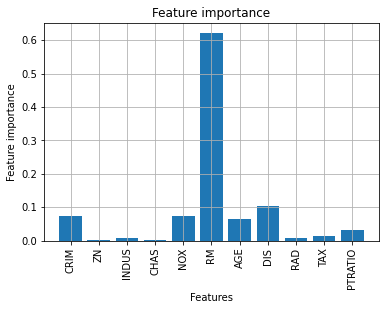

In [ ]:
plt.bar(np.arange(theta.size), best_rf_model.feature_importances_)
plt.xticks(ticks=np.arange(theta.size),labels=dataset['feature_labels'],rotation=90)
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.grid(True)
plt.show()

Los valores de feature importance suman 1, y pueden interpretarse como el "porcentaje de importancia" de cada una de ellas. Puede observarse que más del 50% de la capacidad del regresor está explicada en este caso por RM. Si además comparamos este gráfico con los que generamos antes para los coeficientes de Ridge regression y LASSO, vamos a ver que en ambos casos RM fue el descriptor más pesado. Esto puede indicar que esta característica es quizá la que está más relacionada con la variable objetivo.

Estos análisis resultan interesantes en general para sacar conclusiones respecto a los datos con los que estamos trabajando.

### 7. Evaluación y comparación de modelos

Vamos a hacer una evaluación final de los 3 mejores algoritmos de acuerdo a los datos de validación, pero esta vez sobre los datos de test. Lo haremos en función de todas las métricas que vimos, y también graficaremos el error absoluto para ver qué ocurre.

In [ ]:
from sklearn.metrics import mean_absolute_error

# juntamos todos los modelos en una única lista
models_for_evaluation = [best_ridge_model, best_lasso_model, best_rf_model]
model_tags = ['Ridge', 'LASSO', 'RF']
# inicializamos los arreglos donde vamos a ir guardando los valores a comparar
mae_test = np.zeros(len(models_for_evaluation))
mse_test = np.zeros(len(models_for_evaluation))
r2_test = np.zeros(len(models_for_evaluation))
differences_in_prediction = []

# iteramos por cada modelo
for i in range(len(models_for_evaluation)):
  # generamos las predicciones con el método
  y_hat_test = models_for_evaluation[i].predict(dataset['X_test'])
  # evaluamos en términos de MAE
  mae_test[i] = mean_absolute_error(dataset['y_test'], y_hat_test)
  # evaluamos en términos de MSE
  mse_test[i] = mean_squared_error(dataset['y_test'], y_hat_test)
  # podemos también calcular el R2 sobre los datos de test
  r2_test[i] = models_for_evaluation[i].score(dataset['X_test'], dataset['y_test'])
  # y finalmente sacar las diferencias respecto a los valores que correspondian
  current_differences = np.absolute(np.squeeze(dataset['y_test']) - np.squeeze(y_hat_test))
  differences_in_prediction.append(current_differences)

print('Mean Absolute Error')
print('==========================')
for i in range(len(model_tags)):
  print('--> {} \t MAE = {:.4f}'.format(model_tags[i], mae_test[i]))
print('==========================\n')

print('Mean Squared Error')
print('==========================')
for i in range(len(model_tags)):
  print('--> {} \t MSE = {:.4f}'.format(model_tags[i], mse_test[i]))
print('==========================\n')

print('R2')
print('==========================')
for i in range(len(model_tags)):
  print('--> {} \t R2 = {:.4f}'.format(model_tags[i], r2_test[i]))
print('==========================\n')

Mean Absolute Error
--> Ridge 	 MAE = 3.5831
--> LASSO 	 MAE = 3.6034
--> RF 	 MAE = 2.5169

Mean Squared Error
--> Ridge 	 MSE = 24.2630
--> LASSO 	 MSE = 24.0658
--> RF 	 MSE = 12.9839

R2
--> Ridge 	 R2 = 0.7353
--> LASSO 	 R2 = 0.7374
--> RF 	 R2 = 0.8583



Tanto el MAE como el MSE son mejores cuando son más bajos, mientras que el R2 es mejor cuando es más cercano a 1. En este análisis sobre los datos de validación vemos que el modelo basado en RF es el que mejor trabaja sobre estos datos.

Podríamos también graficas estas métricas, para que sea más fácil interpretarlas.

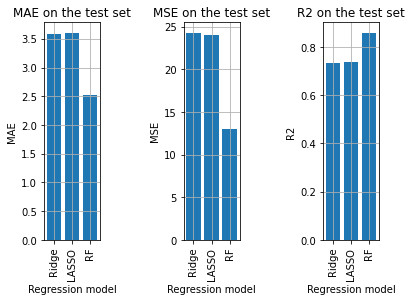

In [ ]:
# generamos graficas comparando los valores de MAE, MSE y R2
fig, axes = plt.subplots(1, 3)
plt.subplots_adjust(wspace=1.5)
# mae
axes[0].bar(np.arange(len(models_for_evaluation)), mae_test)
axes[0].set_title('MAE on the test set')
axes[0].set_xlabel('Regression model')
axes[0].set_ylabel('MAE')
axes[0].set_xticks(np.arange(len(model_tags)))
axes[0].set_xticklabels(labels=model_tags, rotation=90)
axes[0].grid(True)
# mse
axes[1].bar(np.arange(len(models_for_evaluation)), mse_test)
axes[1].set_title('MSE on the test set')
axes[1].set_xlabel('Regression model')
axes[1].set_ylabel('MSE')
axes[1].set_xticks(np.arange(len(model_tags)))
axes[1].set_xticklabels(labels=model_tags, rotation=90)
axes[1].grid(True)
# R2
axes[2].bar(np.arange(len(models_for_evaluation)), r2_test)
axes[2].set_title('R2 on the test set')
axes[2].set_xlabel('Regression model')
axes[2].set_ylabel('R2')
axes[2].set_xticks(np.arange(len(model_tags)))
axes[2].set_xticklabels(labels=model_tags, rotation=90)
axes[2].grid(True)
plt.show()

Y podemos graficar en un boxplot el error absoluto, para estudiar las diferencias en predicción más en detalle.

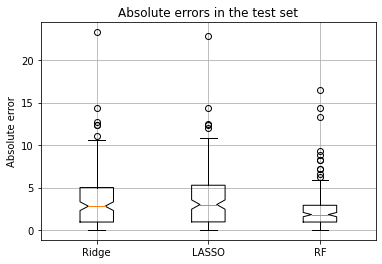

In [ ]:
# y ahora podemos plotear los errores usando un boxplot
plt.boxplot(np.transpose(np.asarray(differences_in_prediction), axes=(1,0)),notch=True)
plt.grid(True)
plt.ylabel('Absolute error')
plt.title('Absolute errors in the test set')
plt.xticks(ticks=np.arange(len(model_tags))+1, labels=model_tags)
plt.show()

Podemos ver que, en linea con los valores de MAE, MSE y R2, Ridge y LASSO tienen una performance muy similar, mientras que el modelo de Random Forest tiene errores que se distribuyen más cerca del 0.

Y con eso tenemos todas las herramientas para hacer el práctico de regresión :)